# Smiles Embedding:
### Use cddd to encode smiles (yippeeee)

In [ ]:
import os
import csv
import pandas as pd
import numpy as np

from cddd.inference import InferenceModel

# import and preprocess dataset

input_csv = "computed_spectra.csv"
output_csv = "spectra_and_embeddings_full.csv"
row_num = 0

# create an instance of the model
inference_model = InferenceModel()
print("created model")

# skip preprocessing if file already exists
if os.path.exists(output_csv):
    print(f"{output_csv} already exists. loading data... ")

    df = pd.read_csv(output_csv)
    smiles_list = df["smiles"].tolist() # FIX

    spectra_array = df.iloc[:, 1:1802].values   # spectra columns
    embedded_smiles = df.iloc[:, 1802:].values  # embedded SMILES columns

    print("spectra shape: ", spectra_array.shape)
    print("embedded smiles shape: ", embedded_smiles.shape)

else:
    print("Processing raw SMILES and spectra...")

    smiles_list = []
    spectra_list = []

    with open(input_csv, "r") as f:
        total_rows = sum(1 for _ in f) - 1  # minus 1 for header

    with open(input_csv, "r") as f:
        reader = csv.reader(f)
        header = next(reader)  # e.g., ["smiles", "spectrum_0", ..., "spectrum_1800"]
        for row in reader:
            row_num += 1
            if row_num % 1000 == 0:
                print(f"Processed {row_num}/{total_rows}")
            smiles = row[0].strip()
            spectrum = [float(val) for val in row[1:]]
            try:
                smiles_list.append(smiles)
                spectra_list.append(spectrum)
            except:
                continue

    spectra_array = np.array(spectra_list)  # shape (N, 1801)


    # encode all SMILES into the continuous embedding --> size 512
    print("encoding SMILES...")
    embedded_smiles = inference_model.seq_to_emb(smiles_list)  # shape (N, 512)
    print("embedding shape:", embedded_smiles.shape)

    # combine all data: smiles + spectra + embeddings
    combined_array = np.hstack((np.array(smiles_list).reshape(-1, 1), spectra_array, embedded_smiles))

    # create headers
    spectra_headers = [f"spectrum_{i}" for i in range(spectra_array.shape[1])]
    embed_headers = [f"emb_{i}" for i in range(embedded_smiles.shape[1])]
    headers = ["smiles"] + spectra_headers + embed_headers

    # create DataFrame and save
    combined_df = pd.DataFrame(combined_array, columns=headers)
    combined_df.to_csv(output_csv, index=False)
    print(f"saved new file: {output_csv}")

# set USE_SMALL_SUBSET to True to limit to specific number of rows instead of defaulting to entire dataset
USE_SMALL_SUBSET = False
MAX_ROWS = 10000

if USE_SMALL_SUBSET:
    print(f"Truncating dataset to first {MAX_ROWS} rows for testing.")
    smiles_list = smiles_list[:MAX_ROWS]
    spectra_array = spectra_array[:MAX_ROWS]

created model
spectra_and_embeddings_full.csv already exists. loading data... 
spectra shape:  (85506, 1801)
embedded smiles shape:  (85506, 512)


# Normalize & Smooth Spectra

In [ ]:
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler


spec_len = 1801 

# normalize
scaler = MinMaxScaler()
normalized_spectra = scaler.fit_transform(spectra_array)

# check if normalization worked 
print("Normalized spectra shape:", normalized_spectra.shape)
print("Sample normalized spectrum:", normalized_spectra[0][:10])

# Smooth each spectrum
smoothed_spectra = [savgol_filter(spectrum, window_length=15, polyorder=3) for spectrum in normalized_spectra]

# covert back to np array
smoothed_spectra = np.array(smoothed_spectra)
Y = smoothed_spectra 

# check if smoothing worked
print("Smoothed spectra shape:", smoothed_spectra.shape)
print("Example smoothed spectrum:", smoothed_spectra[0][:10])


Normalized spectra shape: (85506, 1801)
Sample normalized spectrum: [0.0086403  0.00853724 0.00871799 0.00868892 0.00868103 0.00868275
 0.00859874 0.00842945 0.00839367 0.00825264]


/home/undergrad/2026/wcarvalh/miniconda3/envs/cddd/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Smoothed spectra shape: (85506, 1801)
Example smoothed spectrum: [0.00859377 0.00865254 0.00868034 0.00868118 0.00865905 0.00861796
 0.00856189 0.00849487 0.00843585 0.00833556]


# Pad Smiles

In [ ]:
def pad_embeddings(embeddings, target_dim=1802):
    current_dim = embeddings.shape[1]
    if 2 * current_dim > target_dim:
        raise ValueError("Embedding too large")
    gap = target_dim - 2 * current_dim
    zeros = np.zeros((embeddings.shape[0], gap))
    return np.concatenate([embeddings, zeros, embeddings], axis=1)

X_padded = pad_embeddings(embedded_smiles, target_dim=1802)  # for forward model
X_raw = embedded_smiles  # for reverse model

# Split into train & test sets

In [ ]:
from sklearn.model_selection import train_test_split

# clip to smallest length
min_len = min(len(X_padded), len(Y))
X_padded = X_padded[:min_len]  # forward spectra (padded embedding)
X_raw = X_raw[:min_len]        # reverse embedding (no padding)
Y = Y[:min_len]                # spectra

# pad Y to ensure all tensors have same length
zeros = np.zeros((Y.shape[0], 1))  # for alignment
Y = np.hstack([Y, zeros])

# 1st split: train (70%) & temp (30%)
Xf_train, Xf_temp, Xr_train, Xr_temp, Y_train, Y_temp, smiles_train, smiles_temp = train_test_split(
    X_padded, X_raw, Y, smiles_list, test_size=0.3, random_state=42
)

# 2nd Split: temp -> validation (15%) + test (15%) ---
Xf_val, Xf_test, Xr_val, Xr_test, Y_val, Y_test, smiles_val, smiles_test = train_test_split(
    Xf_temp, Xr_temp, Y_temp, smiles_temp, test_size=0.5, random_state=42
)


# Dataset:

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class SpectraEmbeddingDataset(Dataset):
    def __init__(self, spectra_data, embedding_data):
        self.spectra = torch.tensor(spectra_data, dtype=torch.float32)
        self.embeddings = torch.tensor(embedding_data, dtype=torch.float32)

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return self.spectra[idx], self.embeddings[idx]

class EmbeddingDataset(Dataset):
    def __init__(self, embedding_data, spectra_data):
        self.embedding = torch.tensor(embedding_data, dtype=torch.float32)
        self.spectra = torch.tensor(spectra_data, dtype=torch.float32)

    def __len__(self):
        return len(self.embedding)

    def __getitem__(self, idx):
        return self.embedding[idx], self.spectra[idx]

# datasets
train_dataset = SpectraEmbeddingDataset(Xf_train, Y_train)
test_dataset = SpectraEmbeddingDataset(Xf_test, Y_test)
val_dataset = SpectraEmbeddingDataset(Xf_val, Y_val)

# dataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_dataset_rev = EmbeddingDataset(Xr_train, Y_train)     # reverse direction
val_dataset_rev   = EmbeddingDataset(Xr_val, Y_val)
test_dataset_rev  = EmbeddingDataset(Xr_test, Y_test)

train_loader_rev = DataLoader(train_dataset_rev, batch_size=64, shuffle=True)
val_loader_rev   = DataLoader(val_dataset_rev, batch_size=64, shuffle=False)
test_loader_rev  = DataLoader(test_dataset_rev, batch_size=64, shuffle=False)



In [ ]:
print("X_padded shape:", X_padded.shape)   # should be (N, 1802)
print("X_raw shape:", X_raw.shape)         # should be (N, 512)
print("Y shape:", Y.shape)                 # should be (N, 1802)

X_padded shape: (85506, 1802)
X_raw shape: (85506, 512)
Y shape: (85506, 1802)


In [32]:
class SIDLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, model_spectra, target_spectra):
        model_spectra = torch.clamp(model_spectra, min=self.eps)
        target_spectra = torch.clamp(target_spectra, min=self.eps)

        term1 = model_spectra * torch.log(model_spectra / target_spectra)
        term2 = target_spectra * torch.log(target_spectra / model_spectra)
        loss = term1 + term2
        return loss.sum(dim=1).mean()

# INN Model: (RealNVP)

In [ ]:
from torch.nn import BatchNorm1d
import torch.nn as nn

class CouplingLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        hidden = 512
        self.scale = nn.Sequential(
            nn.Linear(dim // 2, hidden),
            BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, dim // 2),
            nn.Tanh()
        )
        self.translate = nn.Sequential(
            nn.Linear(dim // 2, hidden),
            BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, dim // 2)
        )
    def forward(self, x, reverse=False):
        x1, x2 = x.chunk(2, dim=1)
        s, t = self.scale(x1), self.translate(x1)
        y2 = x2 * torch.exp(s) + t if not reverse else (x2 - t) * torch.exp(-s)
        return torch.cat([x1, y2], dim=1)

class RealNVP(nn.Module):
    def __init__(self, dim, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([CouplingLayer(dim) for _ in range(num_layers)])
    def forward(self, x, reverse=False):
        for layer in (self.layers if not reverse else reversed(self.layers)):
            x = layer(x, reverse=reverse)
        return x

class RealNVPWithProjection(nn.Module):
    def __init__(self, dim, output_dim=1802, num_layers=3):
        super().__init__()
        self.flow = RealNVP(dim, num_layers)
        self.project = nn.Sequential(
            nn.Linear(dim, output_dim),
            nn.Tanh()
        )

    def forward(self, x, reverse=False):
        x = self.flow(x, reverse=reverse)
        if not reverse:
            x = self.project(x)
        return x

# Training Loop (Forward)

In [34]:
# forward model
fwd_model = RealNVPWithProjection(dim=1802, output_dim=1802, num_layers=10)
# reverse model
reverse_model = RealNVPWithProjection(dim=1802, output_dim=512)

# optimizers
optimizer = torch.optim.Adam(fwd_model.parameters(), lr=1e-3)
reverse_optimizer = torch.optim.Adam(reverse_model.parameters(), lr=1e-3)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs = 50
loss_fn = nn.MSELoss()

train_losses = []
val_losses = []

# scheduler and early stopping parameters
patience = 5
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

for epoch in range(num_epochs):
    fwd_model.train()
    total_train_loss = 0

    # training loop
    for (spectra_batch, embedding_batch) in train_loader:
        # forward: embedding → spectra
        optimizer.zero_grad()
        pred_spectra = fwd_model(embedding_batch)
        loss_forward = loss_fn(pred_spectra, spectra_batch)
        loss_forward.backward()
        optimizer.step()
        total_train_loss += loss_forward.item()

    train_losses.append(total_train_loss)

    fwd_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for spectra_batch, embedding_batch in val_loader:
            pred_spectra = fwd_model(embedding_batch)
            loss_forward = loss_fn(pred_spectra, spectra_batch)
          
            total_val_loss += loss_forward.item()

    val_losses.append(total_val_loss)

    # update scheduler
    scheduler.step(total_val_loss)

    print(f"Epoch {epoch+1:02}: Train Loss = {total_train_loss:.4f}, Val Loss = {total_val_loss:.4f}")

    # early stopping
    if total_val_loss + min_delta < best_val_loss:
        best_val_loss = total_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1:02}. No improvement for {patience} consecutive epochs.")
        break


Epoch 01: Train Loss = 88.2927, Val Loss = 17.0499
Epoch 02: Train Loss = 79.6583, Val Loss = 16.3654
Epoch 03: Train Loss = 76.7463, Val Loss = 15.9906
Epoch 04: Train Loss = 74.8489, Val Loss = 15.6926
Epoch 05: Train Loss = 73.4848, Val Loss = 15.3950
Epoch 06: Train Loss = 72.2069, Val Loss = 15.1484
Epoch 07: Train Loss = 71.1588, Val Loss = 15.2598
Epoch 08: Train Loss = 70.2330, Val Loss = 14.8133
Epoch 09: Train Loss = 69.3753, Val Loss = 14.7486
Epoch 10: Train Loss = 68.4925, Val Loss = 14.8418
Epoch 11: Train Loss = 67.8725, Val Loss = 14.6819
Epoch 12: Train Loss = 67.0329, Val Loss = 14.3424
Epoch 13: Train Loss = 66.3732, Val Loss = 14.2828
Epoch 14: Train Loss = 65.8229, Val Loss = 14.2201
Epoch 15: Train Loss = 65.2501, Val Loss = 15.0451
Epoch 16: Train Loss = 64.6120, Val Loss = 14.1256
Epoch 17: Train Loss = 64.0459, Val Loss = 14.1085
Epoch 18: Train Loss = 63.4810, Val Loss = 13.9672
Epoch 19: Train Loss = 62.9235, Val Loss = 13.9017
Epoch 20: Train Loss = 62.4673,

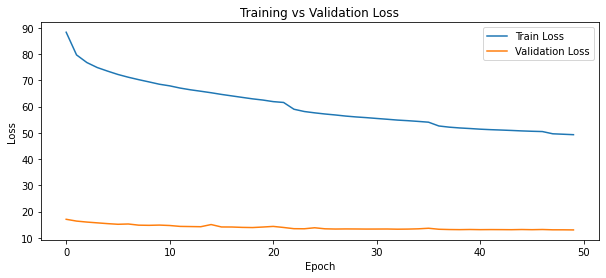

In [37]:
import matplotlib.pyplot as plt

# plot loss graph
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Model Evaluation (Forward)

Test Loss: 69.4135


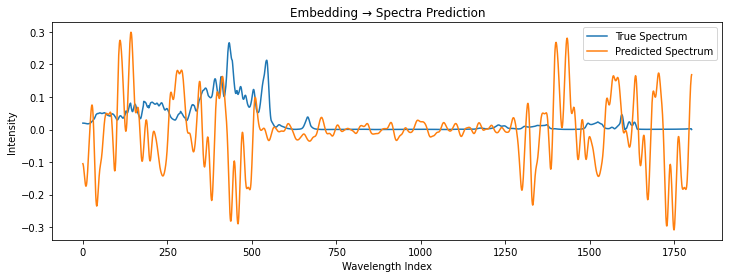

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

fwd_model.eval()
#reverse_model.eval()

test_losses = []
total_test_loss = 0

X_test_list = []
Y_test_list = []
Y_pred_list = []

with torch.no_grad():
    for emb_batch, spec_batch in test_loader:
        # forward pass: emb → spectra)
        pred_spec = fwd_model(emb_batch)
        loss_forward = loss_fn(pred_spec, spec_batch)

        loss = loss_forward
        total_test_loss += loss.item()

        # save for plotting
        X_test_list.append(emb_batch)
        Y_test_list.append(spec_batch)
        Y_pred_list.append(pred_spec)

test_losses.append(total_test_loss)
print(f"Test Loss: {total_test_loss:.4f}")

# combine all batches into full arrays
X_test = torch.cat(X_test_list, dim=0)
Y_test = torch.cat(Y_test_list, dim=0)
Y_pred = torch.cat(Y_pred_list, dim=0)

# smoothing
y_pred_smoothed = gaussian_filter(Y_pred.cpu().numpy(), sigma=6)
y_true = Y_test.cpu().numpy()

# plot one example
idx = 100  
plt.figure(figsize=(12, 4))
plt.plot(y_true[idx], label="True Spectrum")
plt.plot(y_pred_smoothed[idx], label="Predicted Spectrum")
plt.title("Embedding → Spectra Prediction")
plt.xlabel("Wavelength Index")
plt.ylabel("Intensity")
plt.legend()
plt.show()



# Training Loop (Reverse)

In [ ]:
num_epochs = 50
loss_fn = nn.MSELoss()

train_losses = []
val_losses = []

# scheduler and early stopping parameters
patience = 5
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0

# define schedulers for each optimizer
reverse_scheduler = ReduceLROnPlateau(reverse_optimizer, mode='min', factor=0.5, patience=2, verbose=True)

for epoch in range(num_epochs):
    reverse_model.train()
    total_train_loss = 0

    # training loop
    for (embedding_batch_rev, spectra_batch_rev) in train_loader_rev:
        reverse_optimizer.zero_grad()
        pred_embedding = reverse_model(spectra_batch_rev)
        loss_reverse = loss_fn(pred_embedding, embedding_batch_rev[:, :512])  # crop if padded
        loss_reverse.backward()
        reverse_optimizer.step()

        total_train_loss += loss_reverse.item()

    train_losses.append(total_train_loss)

    # validation
    reverse_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for spectra_batch, embedding_batch in val_loader:
            pred_embedding = reverse_model(spectra_batch)
            loss_reverse = loss_fn(pred_embedding, embedding_batch[:, :512])
            total_val_loss += loss_reverse.item()

    val_losses.append(total_val_loss)

    # update schedulers
    reverse_scheduler.step(total_val_loss)

    print(f"Epoch {epoch+1:02}: Train Loss = {total_train_loss:.4f}, Val Loss = {total_val_loss:.4f}")

    # early stopping
    if total_val_loss + min_delta < best_val_loss:
        best_val_loss = total_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1:02}. No improvement for {patience} consecutive epochs.")
        break


Epoch 01: Train Loss = 151.9030, Val Loss = 79.7982
Epoch 02: Train Loss = 137.9313, Val Loss = 86.0211
Epoch 03: Train Loss = 131.9861, Val Loss = 93.0440
Epoch     4: reducing learning rate of group 0 to 6.2500e-05.
Epoch     4: reducing learning rate of group 0 to 5.0000e-04.
Epoch 04: Train Loss = 127.5245, Val Loss = 104.9947
Epoch 05: Train Loss = 120.5192, Val Loss = 100.3100
Epoch 06: Train Loss = 117.6584, Val Loss = 104.9334
Early stopping at epoch 06. No improvement for 5 consecutive epochs.


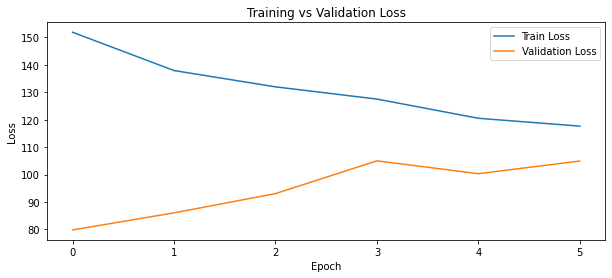

In [40]:
import matplotlib.pyplot as plt

# plot loss graph
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from difflib import SequenceMatcher
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*') 

with torch.no_grad():
    # Y_test = true spectra, shape (N, 1802)
    predicted_embeddings = reverse_model(Y_test).cpu().numpy()  # shape (N, 1802)

print(predicted_embeddings.shape)
print(len(smiles_test))

# store as list of lists
embedding_lists = [row.tolist() for row in predicted_embeddings]

#_, smiles_test = train_test_split(smiles_list, test_size=0.2, random_state=42)

df = pd.DataFrame({
    "True_SMILES": smiles_test,
    "Predicted_Emb": embedding_lists
})

# save as pickle
df.to_pickle("unprocessed_predictions_2.pkl")

# unpad to original embedding dim (if needed)
predicted_embeddings = predicted_embeddings[:, :512]

predicted_smiles = inference_model.emb_to_seq(predicted_embeddings)



(12826, 512)
12826
INFO:tensorflow:Restoring parameters from /home/undergrad/2026/wcarvalh/Documents/uvsq/cddd/cddd/data/default_model/model.ckpt


In [ ]:
import time

output_path = f"decoded_predictions_{len(smiles_test)}.csv"

# check if/how many rows are already saved
if os.path.exists(output_path):
    existing_df = pd.read_csv(output_path)
    start_index = len(existing_df)
    write_header = False
    print(f"Resuming from row {start_index}...")
else:
    start_index = 0
    write_header = True
    print("Starting fresh...")

# load from pickle
df = pd.read_pickle("unprocessed_predictions_2.pkl")

# convert list embeddings into np array
predicted_embeddings = np.stack(df["Predicted_Emb"].values)
true_smiles = df["True_SMILES"].tolist()

batch_size = 1000
total = len(predicted_embeddings)
total_batches = int(np.ceil(total / batch_size))

# loop from where we left off
for i in range(start_index, total, batch_size):
    start_time = time.time()

    batch_end = min(i + batch_size, total)
    batch_embs = predicted_embeddings[i:batch_end]
    batch_true_smiles = true_smiles[i:batch_end]

    decoded = inference_model.emb_to_seq(batch_embs)

    batch_df = pd.DataFrame({
        "True_SMILES": batch_true_smiles,
        "Pred_SMILES": decoded
    })
    batch_df.to_csv(output_path, mode='a', header=write_header, index=False)
    write_header = False

    # timer
    elapsed = time.time() - start_time
    print(f"[Batch {i // batch_size + 1}/{total_batches}] Saved {len(batch_embs)} predictions — Took {elapsed:.2f} sec")

print("\n✅ All batches completed or resumed successfully.")

Resuming from row 12826...

✅ All batches completed or resumed successfully.


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from difflib import SequenceMatcher

def tanimoto(s1, s2):
    try:
        mol1 = Chem.MolFromSmiles(s1)
        mol2 = Chem.MolFromSmiles(s2)
        if mol1 is None or mol2 is None:
            return 0.0
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    except:
        return 0.0

def syntax_similarity(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()

# load the CSV  saved earlier
df = pd.read_csv(f"decoded_predictions_{len(smiles_test)}.csv")

# grab true SMILES column
batch_true_smiles = df["True_SMILES"].tolist() 
decoded = df["Pred_SMILES"].tolist()
# make sure decoded column and true smiles column have same length
n_samples = min(10, len(batch_true_smiles), len(decoded))
valid_count = 0

for i in range(n_samples):
    true_smi = batch_true_smiles[i]
    pred_smi = decoded[i]

    is_valid = Chem.MolFromSmiles(pred_smi) is not None
    if is_valid:
        valid_count += 1

    tanimoto_sim = tanimoto(true_smi, pred_smi)
    syntax_sim = syntax_similarity(true_smi, pred_smi)

    print(f"Original:         {true_smi}")
    print(f"Predicted:        {pred_smi}")
    print(f"Valid SMILES:     {is_valid}")
    print(f"Tanimoto Sim:     {tanimoto_sim:.2f}")
    print(f"Syntax Sim:       {syntax_sim:.2f}")
    print("---")

print(f"Valid SMILES: {valid_count}/{n_samples} ({100 * valid_count / n_samples:.1f}%)")


Original:         CC1(C)C=C(CO)c2cc3c(c4c2N1CCC4)Oc1c2c4c(cc1=C3c1c(F)c(F)c(F)c(F)c1C(=O)[O-])C(CO)=CC(C)(C)[N+]=4CCC2
Predicted:        CCOc1cc(C)ccc1N1CC(C(=O)c2ccc3c(c2)NCCC3)=C(C)C=C1O
Valid SMILES:     True
Tanimoto Sim:     0.10
Syntax Sim:       0.13
---
Original:         COc1ccc2sc(N(C)C)c(C(=O)c3ccc(OCCN4CCCCC4)cc3)c2c1
Predicted:        CCOc1ccc(C=Nc2ccc(O)c(C3=NCCc4ccccc43)c2)c(OC)c1
Valid SMILES:     True
Tanimoto Sim:     0.16
Syntax Sim:       0.53
---
Original:         OCc1c(F)c(F)c(F)c(F)c1F
Predicted:        OCc1c(F)c(F)c(F)cc1F
Valid SMILES:     True
Tanimoto Sim:     0.52
Syntax Sim:       0.93
---
Original:         CNc1cccc(C(=O)C(C)(C)C)c1
Predicted:        Cc1ccc(N2CCC(=O)Nc3ccccc32)c(C)c1
Valid SMILES:     True
Tanimoto Sim:     0.12
Syntax Sim:       0.59
---
Original:         O=c1[nH]ccc2nn(C3CCNCC3)c(Nc3ccnc(F)c3)c12
Predicted:        COc1cc(C)cc(C=C2Sc3nc(C)ccc3C(=O)N2c2ccccc2)c1
Valid SMILES:     True
Tanimoto Sim:     0.09
Syntax Sim:       0.25
---
Origina